In [32]:
!pip install japanize-matplotlib &>/dev/null # 日本語フォントをダウンロードする。
from matplotlib import pylab as plt
import japanize_matplotlib
plt.rcParams["figure.dpi"]=140

import numpy as np
import pandas as pd

from pprint import pprint as pprint

In [33]:
# MaxdIはdI緊急事態宣言発令の閾値．報告数．
# lockdownrateは緊急事態宣言時の接触数割合((1-lockdownrate)の割合だけS・I接触を削減する)
# V,dVはワクチン接種済み人口，ワクチン接種数
def calcSIR(N,S,I,R,V,dI,dR,dS,dV,BETA,GAMMA,MaxdI=float('inf'),lockdownrate=0.7):
    rawBETA=np.copy(BETA)
    lockdownBETA=np.copy(BETA)*lockdownrate
    count_nonzero_dv=0
    for t in range(1,NUM_OF_DAYS): #t日目について
        dV.append(dV[-1])
        dR.append(I[-1]*GAMMA)
        dI.append(BETA*np.sum(I[-1],axis=0)*S[-1]-dR[-1])#-(4,2)-(4,2)=>(4,2) #年齢方向に合計
        dS.append(-BETA*np.sum(I[-1],axis=0)*S[-1]-dV[-1])#(4,1)*(4,2)=>(4,2)．(4,2)*(4,2)=>(4,2)

        #Sが0マイナスになりそうな世代のdV[-1]を0に．再度正規化し，当初の傾きを維持する
        
        dV[-1][(S[-1]+dS[-1])<=0]=0
        # dV更新時
        if(count_nonzero_dv!=np.count_nonzero(dV[-1])):
            count_nonzero_dv=np.count_nonzero(dV[-1])
            if(0<np.sum(dV[-1])):
                dV[-1]=dV[-1]/np.sum(dV[-1])*np.sum(dV[0])
            #print("S["+str(t)+"]",S[-1]+np.sum(dS[-1],axis=0))
            #print("dV["+str(t)+"]=",dV[-1])
            #print("sum(dV["+str(t)+"])/sum(N)=",sum(dV[-1])/sum(N))

            dS[-1]=-BETA*np.sum(I[-1],axis=0)*S[-1]-dV[-1]


        s=S[-1]+dS[-1]
        i=I[-1]+dI[-1]
        S.append(s)
        I.append(i)
        #S.append(np.where(0 < s, s, 0))
        #I.append(np.where(0 < i, i, 0))
        R.append(R[-1]+np.sum(dR[-1],axis=0))
        V.append(V[-1]+dV[-1])
        
        #"if(np.isinf(S[-1]).any() and np.isinf(I[-1]).any() and np.isinf(R[-1]).any() and np.isinf(V[-1]).any()):
        if(False):
            print("dS["+str(t)+"]=",dS[-1])
            print("dI["+str(t)+"]=",dI[-1])
            print("dR["+str(t)+"]=",dR[-1])
            print("dV["+str(t)+"]=",dV[-1])
            print("sum(dV["+str(t)+"])/sum(N)=",sum(dV[-1])/sum(N))
            print("S["+str(t)+"]",S[-1])
            print("I["+str(t)+"]",I[-1])
            print("R["+str(t)+"]",R[-1])
            print("V["+str(t)+"]",V[-1])
        
        if(MaxdI/1000000*sum(N)<abs(sum(dI[-1]))):
            BETA=lockdownBETA
        else:
            BETA=rawBETA
        
        if(np.any(I[-1]<=0)):
            print("break: any(I["+str(t)+"]<=0)")
            break
        if(np.any(S[-1]<=0)):
            print("break: any(S["+str(t)+"]<=0)")
            break
        if(np.any(R[-1]<=0)):
            print("break: any(R["+str(t)+"]<=0)")
            break


In [34]:
NUM_OF_DAYS=300
GROUPS=["0-9","10-19","20-29","30-39","40-40","50-59","60-69","70-79","80-89","90-99","100-"]


#GAMMA=np.array([[1/15.7,1/15.7]])#回復率．γ=1/(感染者の平均回復日数)とすることができるらしいので．回復日数を15.7日として
GAMMA=np.array([[1/14]]) #回復率．γ=1/(感染から隔離されるまでの日数)とすることができるらしいので．
GAMMA=GAMMA/len(GAMMA) #11区分

R0=np.array([[1.23]])
#1.32倍（95％信頼区間1.28-1.37）https://www.niid.go.jp/niid/ja/diseases/ka/corona-virus/2019-ncov/10279-covid19-40.html
#0.94 (95%信頼区間 0.90-0.97)，1.23 (95%信頼区間 1.18-1.28)

#N=np.array([[10000000], # 東京 (総人11口，推計人口2021年4月1日)
#            [10000000], # 埼玉
#            [10000000], # 千葉
#            [10000000]])# 神奈川

#https://www.bousai.metro.tokyo.lg.jp/_res/projects/default_project/_page_/001/013/860/47kai/2021052704.pdf
N=np.array([[524939+499632], # 0-9
            [493559+566729], # 10-19
            [753698+863678], # 20-29
            [969877+1038390], # 30
            [1154214+1048170], # 40
            [891332+722755], # 50
            [725312+854575], # 60
            [713342+583971], # 70
            [449314+261441], # 80
            [108999+28732], # 90
            [5142]])# >=100

# 罹患率10万人あたり https://datastudio.google.com/u/0/reporting/c1dfbd03-0aa7-457d-81d2-3ca5be34706b/page/KNtNB?s=mM99TXFS68A
# 「同性同世代10万人あたり何人感染しているか。……かかりやすさを比較」
ALPHA=np.array([[413.05+399.74], # 0-9
                [871.69+749.47], # 10-19
                [2551.66+2330.63], # 20-29
                [1821.6+1268.86], # 30
                [1336.05+842.52], # 40
                [1249.87+922.23], # 50
                [945.98+655.33], # 60
                [748.8+566.84], # 70
                [952.52+804.37], # 80
                [1393.54+1336.56], # 90
                [2597.4+1582.82]])# >=100

ALPHA=ALPHA/np.sum(ALPHA)

#ワクチン接種速度[/day]．Nと同じ形の行列np.array()で年齢別に設定．
# 全人口に対する割合で設定していある(`*(1/100)*np.sum(N)`の部分)．
OMEGA=np.array([[0], # <10
            [0], # 10-19
            [0], # 20-29
            [0], # 30
            [0], # 40
            [0], # 50
            [0.5], # 60
            [1], # 70
            [1], # 80
            [1], # 90
            [1]])# >=100
OMEGA=OMEGA*N#/np.sum(N)
OMEGA=OMEGA/np.sum(OMEGA)
OMEGA=OMEGA*(1/100)*np.sum(N) #1%/day

dV=[np.copy(OMEGA)]

S=[np.copy(N)]

# 年齢別感染者数/全感染者 東京都 直近1週間 5/18-5/24
#【感染状況】①-2 新規陽性者数（年代別）より
I=[4710*ALPHA]
R=[np.array([[0], # <10
            [0], # 10-19
            [0], # 20-29
            [0], # 30
            [0], # 40
            [0], # 50
            [0], # 60
            [0], # 70
            [0], # 80
            [0], # 90
            [0]])]# >100

V=[np.array([[0], # <10
            [0], # 10-19
            [0], # 20-29
            [0], # 30
            [0], # 40
            [0], # 50
            [0], # 60
            [0], # 70
            [0], # 80
            [0], # 90
            [0]])]# >100


dS=[np.array([[0], # <10
            [0], # 10-19
            [0], # 20-29
            [0], # 30
            [0], # 40
            [0], # 50
            [0], # 60
            [0], # 70
            [0], # 80
            [0], # 90
            [0]])]# >100
dI=[np.array([[0], # <10
            [0], # 10-19
            [0], # 20-29
            [0], # 30
            [0], # 40
            [0], # 50
            [0], # 60
            [0], # 70
            [0], # 80
            [0], # 90
            [0]])]# >100
dR=[np.array([[0], # <10
            [0], # 10-19
            [0], # 20-29
            [0], # 30
            [0], # 40
            [0], # 50
            [0], # 60
            [0], # 70
            [0], # 80
            [0], # 90
            [0]])]# >100

# R0=β/γ
print("N=",N)
print("np.sum(N)=",np.sum(N))

print("γ=",GAMMA)

print("α=",ALPHA)
print("sum(α)=",np.sum(ALPHA))

BETA=R0*GAMMA*ALPHA #BETA=R0*GAMMA (R0の定義より)
print("β=γR0*α=",BETA)
print("sum(β)=",np.sum(BETA))
BETA=BETA/N
print("β/N=",BETA)

print("dV[0]=",dV[0])
print("sum(dV[0])=",sum(dV[0]))
print("validation sum(dV[0])/sum(N)=",np.sum(dV[0])/np.sum(N))

#calcSIR(S,I,R,dI,dR,dS,BETA,GAMMA,MaxdI=1,lockdownrate=0.3)#MaxdIは人口十万人あたり
calcSIR(N=N,S=S,I=I,R=R,V=V,dI=dI,dR=dR,dS=dS,dV=dV,BETA=BETA,GAMMA=GAMMA)


#print("dS[1]=",dS[1])
#print("dI[1]=",dI[1])
#print("dR[1]=",dR[1])
#print("dV[1]=",dV[1])
#print("S[1]=",S[1])
#print("I[1]=",I[1])
#print("R[1]=",R[1])
#print("V[1]=",V[1])
#print("dS[-1]=",dS[-1])
#print("dI[-1]=",dI[-1])
#print("dR[-1]=",dR[-1])
#print("dV[-1]=",dV[-1])
#print("S[-1]=",S[-1])
#print("I[-1]=",I[-1])
#print("R[-1]=",R[-1])
#print("V[-1]=",V[-1])


N= [[1024571]
 [1060288]
 [1617376]
 [2008267]
 [2202384]
 [1614087]
 [1579887]
 [1297313]
 [ 710755]
 [ 137731]
 [   5142]]
np.sum(N)= 13257801
γ= [[0.07142857]]
α= [[0.03085584]
 [0.06154388]
 [0.18534573]
 [0.11732272]
 [0.08270476]
 [0.08245914]
 [0.06079032]
 [0.04994547]
 [0.06669658]
 [0.10364242]
 [0.15869314]]
sum(α)= 1.0
β=γR0*α= [[0.00271091]
 [0.00540707]
 [0.01628395]
 [0.01030764]
 [0.0072662 ]
 [0.00724462]
 [0.00534086]
 [0.00438807]
 [0.00585977]
 [0.00910573]
 [0.01394233]]
sum(β)= 0.08785714285714286
β/N= [[2.64589357e-09]
 [5.09962349e-09]
 [1.00681263e-08]
 [5.13260395e-09]
 [3.29924491e-09]
 [4.48837314e-09]
 [3.38053525e-09]
 [3.38242658e-09]
 [8.24443174e-09]
 [6.61124016e-08]
 [2.71145965e-06]]
dV[0]= [[    0.        ]
 [    0.        ]
 [    0.        ]
 [    0.        ]
 [    0.        ]
 [    0.        ]
 [35611.44181026]
 [58484.16552474]
 [32041.54515335]
 [ 6209.0510169 ]
 [  231.80649475]]
sum(dV[0])= [132578.01]
validation sum(dV[0])/sum(N)= 0.010000000

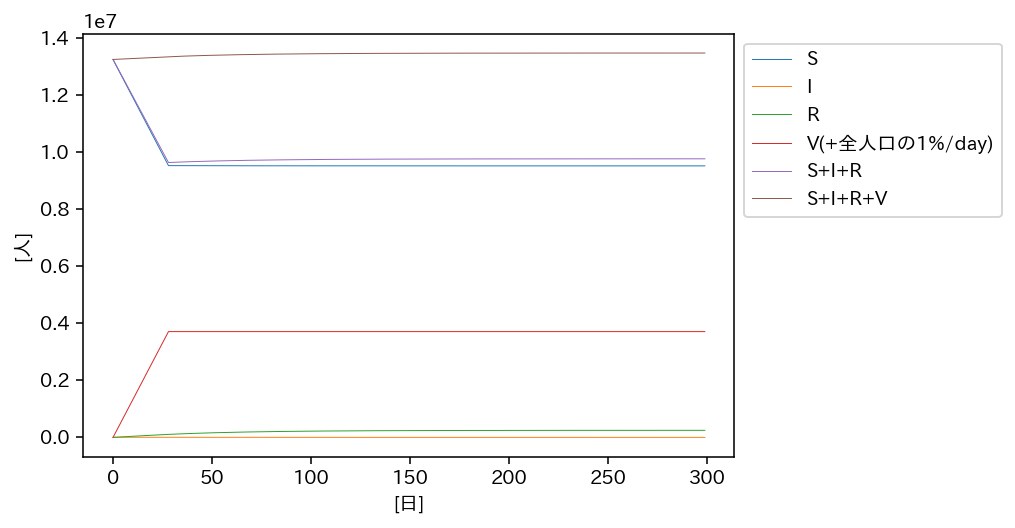

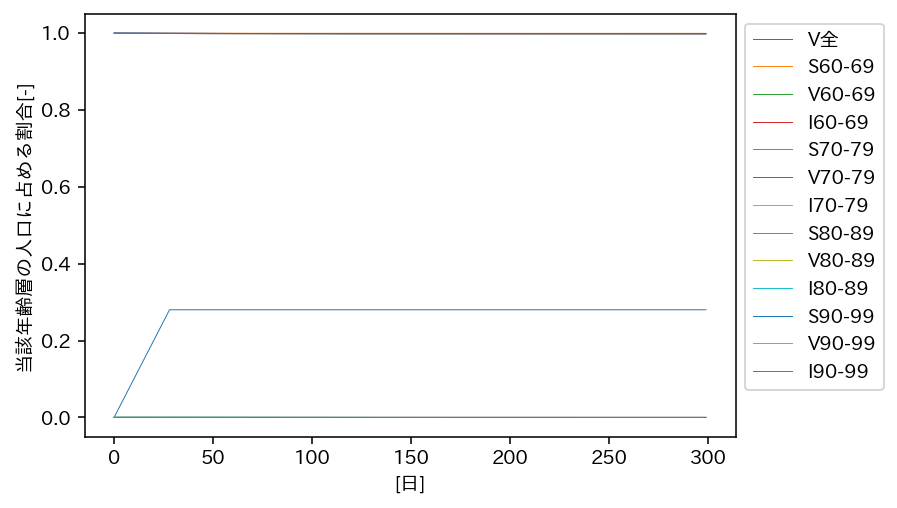

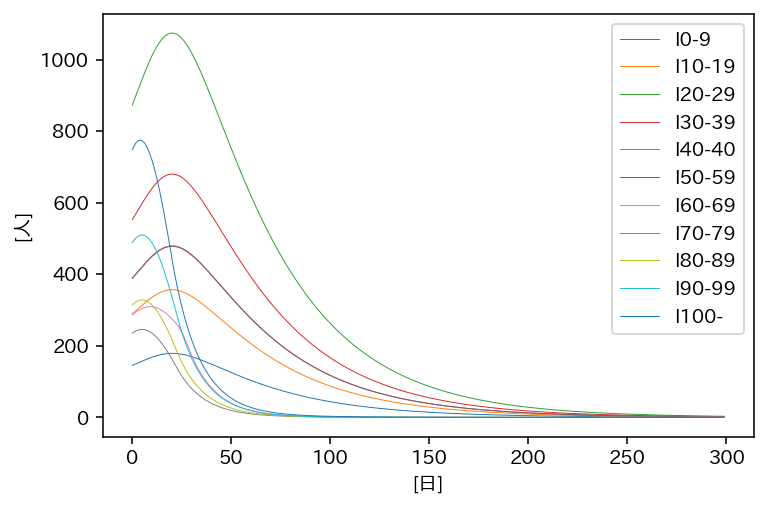

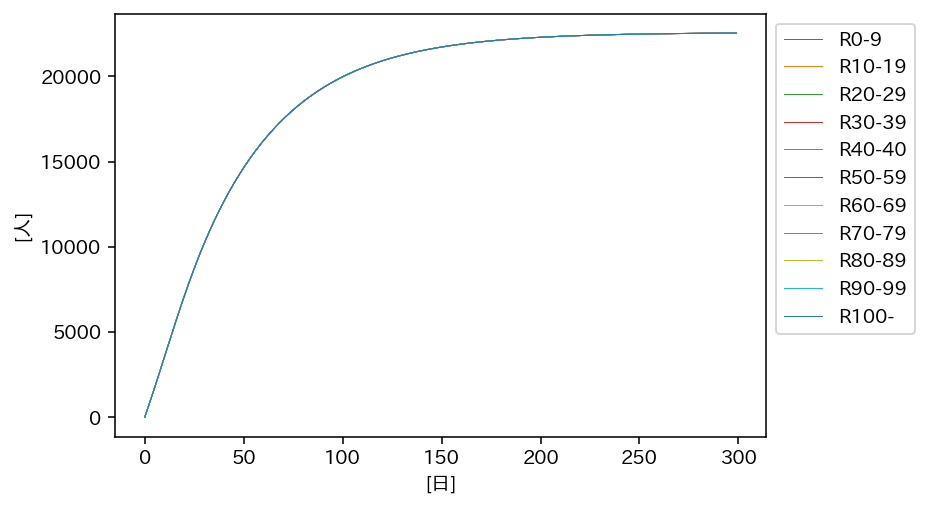

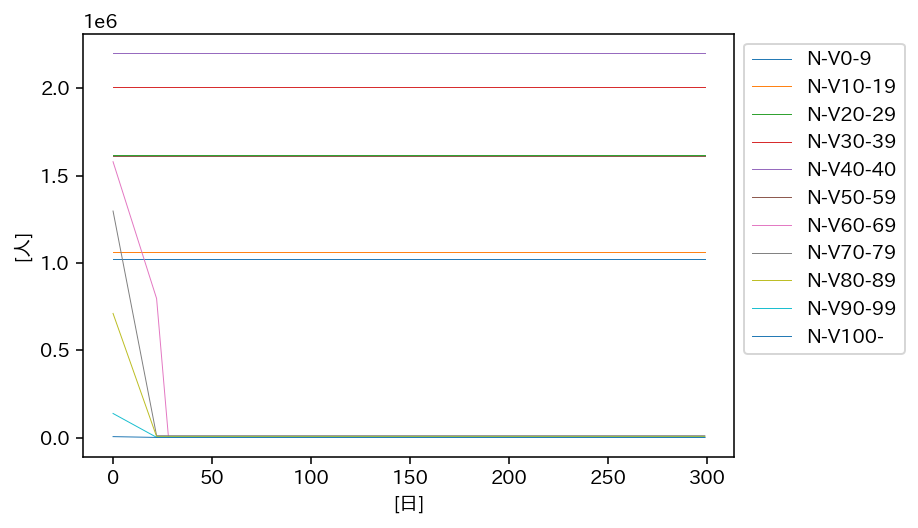

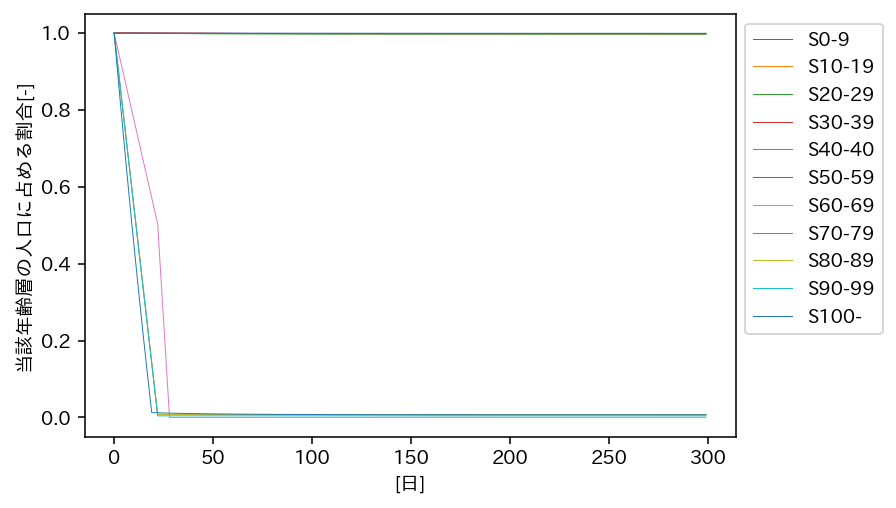

In [31]:
# plot

T=range(0,NUM_OF_DAYS)

plt.plot([sum(s) for s in S], label="S", linewidth=.5)
plt.plot([sum(i) for i in I], label="I", linewidth=.5)
plt.plot([sum(r) for r in R], label="R", linewidth=.5)
plt.plot([sum(v) for v in V], label="V(+全人口の1%/day)", linewidth=.5)
plt.plot([sum(S[t])+sum(I[t])+sum(R[t]) for t in T], label="S+I+R", linewidth=.5)
plt.plot([sum(S[t])+sum(I[t])+sum(R[t])+sum(V[t]) for t in T], label="S+I+R+V", linewidth=.5)
plt.xlabel("[日]")
plt.ylabel("[人]")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

plt.plot([sum([vv for vv in v]) for v in V]/np.sum(N), label="V全", linewidth=.5)
#p_65=N[7:10]+N[6]/2 #65-69歳の人数はわからないので，60代の半分とする
for k, age in enumerate(GROUPS[6:10]):
    #plt.plot([(S[t][k][0]+I[t][k][0]+R[t][k][0]+V[t][k][0])/N[k] for t in T], label="S+I+R+V"+str(v), linewidth=.5)
    plt.plot([(S[t][k][0])/N[k] for t in T], label="S"+str(age), linewidth=.5)
    plt.plot([(V[t][k][0])/N[k] for t in T], label="V"+str(age), linewidth=.5)
    plt.plot([(I[t][k][0])/N[k] for t in T], label="I"+str(age), linewidth=.5)
plt.xlabel("[日]")
plt.ylabel("当該年齢層の人口に占める割合[-]")
plt.legend(bbox_to_anchor=(1,1))
plt.show()


for k, age in enumerate(GROUPS):
    plt.plot([i[k][0] for i in I], label="I"+str(age), linewidth=.5)
plt.xlabel("[日]")
plt.ylabel("[人]")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

for k, age in enumerate(GROUPS):
    plt.plot([r[k][0] for r in R], label="R"+str(age), linewidth=.5)
plt.xlabel("[日]")
plt.ylabel("[人]")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

for k, age in enumerate(GROUPS):
    plt.plot([N[k]-v[k][0] for v in V], label="N-V"+str(age), linewidth=.5)
plt.xlabel("[日]")
plt.ylabel("[人]")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

for k, age in enumerate(GROUPS):
    plt.plot([s[k][0]/N[k] for s in S], label="S"+str(age), linewidth=.5)
plt.xlabel("[日]")
plt.ylabel("当該年齢層の人口に占める割合[-]")
plt.legend(bbox_to_anchor=(1,1))
plt.show()
